<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform following steps:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

In [ ]:
!pip install -q condacolab

In [ ]:
import condacolab

In [ ]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda --version

conda 23.11.0


In [ ]:
!which conda

/usr/local/bin/conda


In [ ]:
!conda config --add channels conda-forge

In [ ]:
!conda config --add channels bioconda

In [ ]:
!pip install snapatac2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip show snapatac2

Name: snapatac2
Version: 2.7.1
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [ ]:
import snapatac2 as snap

In [ ]:
!pip install umap-learn -q



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 62.2 MB/s eta 0:00:00


In [ ]:
import umap.umap_ as umap


In [ ]:
from umap import UMAP

In [ ]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━

In [ ]:
import scanpy as sc

In [ ]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [ ]:
!pip install magic-impute -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install leidenalg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00


In [ ]:
import numpy as np

In [ ]:
import anndata as ad

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [ ]:
import seaborn as sns

# Import reads from google drive, three samples treated with energy metabolism inhibitors and one untreated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load AD matrix from google drive, PCA and Batch corrected
MTXmerged_PC_BC = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/MTXmerged_PCA_BC.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata_concat = MTXmerged_PC_BC

In [ ]:
!rm MTXmerged_PC_BC

rm: cannot remove 'MTXmerged_PC_BC': No such file or directory


Plot the 'obsm' before and after batch effect removal (PC1 vs PC2)

In [ ]:
#Extract data sets
x_before = adata_concat.obsm['X_pca'][:, 0]
y_before = adata_concat.obsm['X_pca'][:, 1]

x_after = adata_concat.obsm['X_pca_harmony'][:, 0]
y_after = adata_concat.obsm['X_pca_harmony'][:, 1]
batch_labels = adata_concat.obs['Treatment']


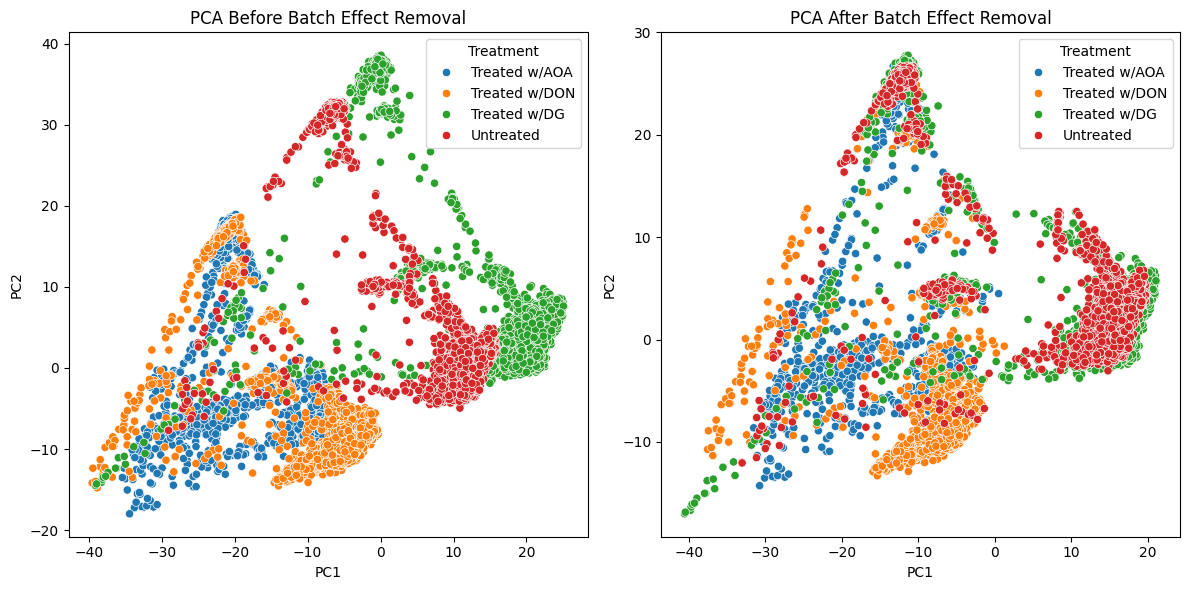

In [39]:
#Define figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#Plot before batch effect removal

sns.scatterplot(x=x_before, y=y_before, hue=batch_labels)
plt.title('PCA Before Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

#Plot PCA after batch effect removal

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_after, y=y_after, hue=batch_labels)
plt.title('PCA After Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

In [ ]:
from shutil import copyfile

In [ ]:
copyfile('adata_concat.h5ad', '/content/drive/MyDrive/Colab Notebooks/adata_concat.h5ad')

In [ ]:
adata_concat

# Differential accesibility analysis

In [ ]:
import numpy as np

In [ ]:
from scipy import stats

In [ ]:
# Assuming adata is your AnnData object
condition1 = adata_concat[adata_concat.obs['Treatment'] == 'Treated w/AOA']
condition2 = adata_concat[adata_concat.obs['Treatment'] == 'Untreated']

In [ ]:
# Perform a t-test for each peak/gene
pvals = []
for peak in adata_concat.var_names:
 _, pval = stats.ttest_ind(condition1[:, peak].X.toarray(), condition2[:, peak].X.toarray())
 pvals.append(pval)

In [ ]:
# Adjust p-values for multiple testing (e.g., using Benjamini-Hochberg)
from statsmodels.stats.multitest import multipletests
_, pvals_adj, _, _ = multipletests(pvals, method='fdr_bh')

In [ ]:
# Add p-values to AnnData object
adata.var['pvals'] = pvals
adata.var['pvals_adj'] = pvals_adj

In [ ]:
Filter Significant DARs: Filter the results to retain only those regions that are significantly differentially accessible after multiple testing correction.

In [ ]:
significant_dars = adata.var[adata.var['pvals_adj'] < 0.05]

In [ ]:
Visualize Results: Visualize the differentially accessible regions using various plotting functions available in scanpy or other visualization libraries.

In [ ]:
sc.pl.heatmap(adata, var_names=significant_dars.index, groupby='condition')

Interpret Results: Interpret the biological significance of the differentially accessible regions. This might involve looking at the genes associated with these regions and understanding their roles in the biological conditions you are studying.